# Grocery Store Model

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import Image
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

#Import from created .py script
from grocerystore import process_sim_output

In [2]:
#Refresh libraries
%reload_ext autoreload
%autoreload 2

In [3]:
#Matplotlib Magic Command
%matplotlib inline

## About the model
### Overview
This project uses the SimPy environment to model a basic grocery store. 
The entities for this model are customers. The model maps the customers’ trip through the grocery store, records key time stamps, and performs some basic preprocessing. 
### Customers Arrive and Get A Cart
Customers arrive according to an exponential distribution. Once a customer enters the store, they request a cart. If a cart is unavailable, the customer must wait. This time it takes customers to pull a cart is uniform distribution. The customer keeps the cart resource until they exit the system.
Each customer has a set time it takes them to decide pick one item and walk to the next location. This is based on a normal distribution. The default estimates for this distribution are logical but not based on actual data. 
### The Departments
Customers pick items from three departments. The number of items from each department is governed by a normal distribution. The distribution is post processed to round to the nearest integer and floor negative numbers at zero.  
* Produce
    * The total time in the produce department is the product of the time it takes to pick an item and the number of produce items. 
* Butcher
	* Only a limited percentage of customers need to see the butcher. If a customer doesn’t need to see the butcher, they skip this step and go directly to produce. Customers that do need to see the butcher request the resource. If one is unavailable, they must wait. The time the butcher requires to process the an item is a log-normal distribution. The total time at the butcher station is the sum of the time it takes a customer to pick and a butcher to process an item times the number of items. The mean of the number of items from the butcher is the lowest of all three departments.
* Pantry
    * The pantry department is very similar to produce. There are no constrained resources. The mean is slightly higher than the produce department. The time in the pantry department is the product of number of items and the time it takes to pick one item.
### The Checkout
After customers finish selecting all their items, they go request a cashier to checkout. If a cashier is unavailable, the customer must wait. The cashier’s processing time per item is a log-normal distribution. The scanning time per item is unique for each customer. I struggled to find default statistics to make this distribution logical, so I added it to the summary statistics. My initial attempt had some cashiers spending five minutes per item. [This site]( https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html) from the University of Iowa allowed me to try several distributions until I found the correct probability. A negative mean for the log-normal cashier distribution was key. The time at the cashier is the product if total number of items and the cashier’s scanning time per item. 
### Exit the System
Once the checkout is complete, the customer releases the cashier and their cart and exits the system.

## Visualize the Model

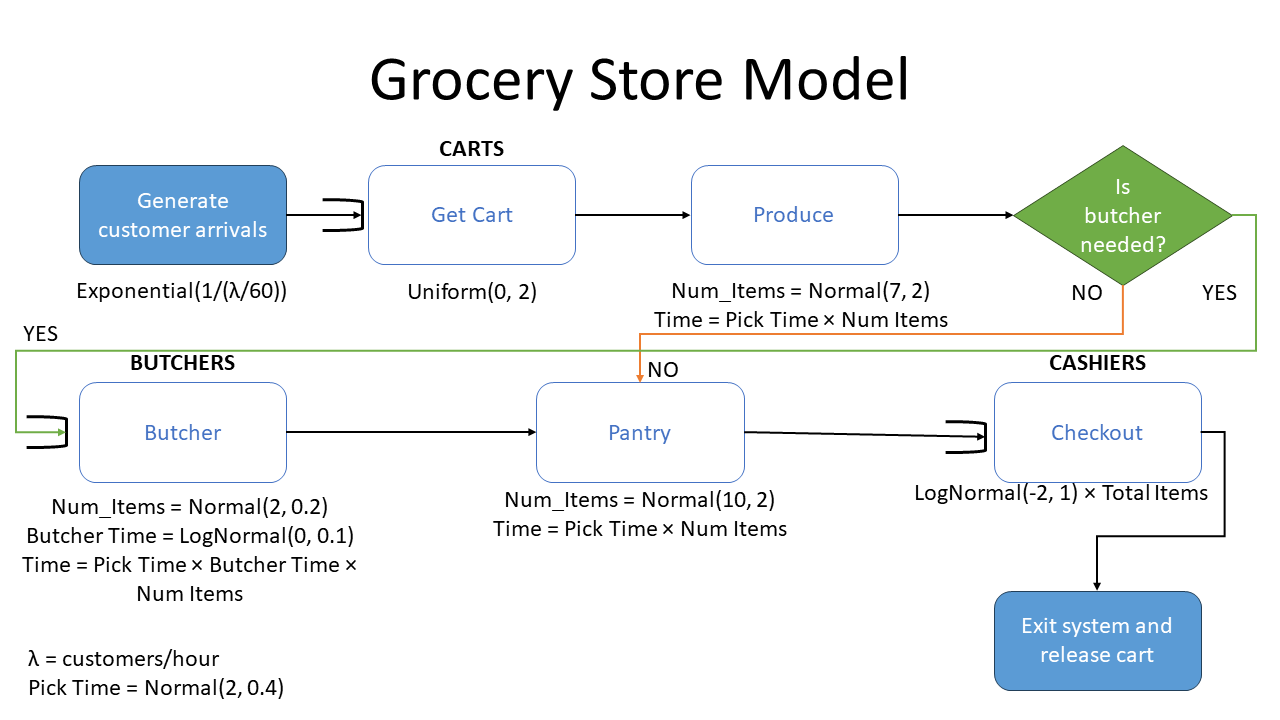

In [4]:
Image("images/Visualize_Model.png")

## Running Model
Now, let's run the model. I used the [vaccine clinic model from misken](http://www.sba.oakland.edu/faculty/isken/courses/mis6900_s22/mod4_des_simpy.html) as a base. I changed the model to fit my grocery store as described above. Additionally, I made the resulting performance metrics an input for for the process_sim_output package. This input is not in the config file, but if a user installs the package the analyzed metrics can change. Running this separately also requires some clarification of the wildcards in file names and moving the `unlink()` statement to the main function. Otherwise the program deletes the inputs required to for `process_sim_output()`.

In [12]:
#Run the model with config files using command line prompts
!python ../src/grocerystore/grocerystore.py --config ../src/grocerystore/input/base.cfg

Namespace(butcher_mean=2.0, butcher_sd=0.5, butcher_time_mean=0.0, butcher_time_sigma=0.1, cashier_time_mean=-2.0, cashier_time_sigma=1.0, config=None, customer_arrival_rate=150.0, get_cart_max=2.0, num_butchers=1, num_carts=300, num_cashiers=12, num_reps=10, output_path='output', pantry_mean=10.0, pantry_sd=2.0, pct_need_butcher=0.2, pick_time_mean=2.0, pick_time_sd=0.4, produce_mean=7.0, produce_sd=2.0, quiet=True, scenario='base', seed=8842, stoptime=1080.0)
2703 customers processed.
Simulation replication 1 ended at time 1135.2819190132448
2682 customers processed.
Simulation replication 2 ended at time 1161.6231624209743
2719 customers processed.
Simulation replication 3 ended at time 1149.5067732755774
2800 customers processed.
Simulation replication 4 ended at time 1131.323799738262
2670 customers processed.
Simulation replication 5 ended at time 1149.575339029543
2748 customers processed.
Simulation replication 6 ended at time 1135.0371994484801
2737 customers processed.
Simula

In [13]:
!python ../src/grocerystore/grocerystore.py --config ../src/grocerystore/input/base_150c1b18c.cfg

Namespace(butcher_mean=2.0, butcher_sd=0.5, butcher_time_mean=0.0, butcher_time_sigma=0.1, cashier_time_mean=-2.0, cashier_time_sigma=1.0, config=None, customer_arrival_rate=150.0, get_cart_max=2.0, num_butchers=1, num_carts=150, num_cashiers=18, num_reps=10, output_path='output', pantry_mean=10.0, pantry_sd=2.0, pct_need_butcher=0.2, pick_time_mean=2.0, pick_time_sd=0.4, produce_mean=7.0, produce_sd=2.0, quiet=True, scenario='base_150c1b18c', seed=8842, stoptime=1080.0)
2786 customers processed.
Simulation replication 1 ended at time 1129.6358210169712
2691 customers processed.
Simulation replication 2 ended at time 1138.3333932083387
2725 customers processed.
Simulation replication 3 ended at time 1150.4334998971515
2773 customers processed.
Simulation replication 4 ended at time 1129.8964484463438
2756 customers processed.
Simulation replication 5 ended at time 1131.9309481591006
2726 customers processed.
Simulation replication 6 ended at time 1153.1895415020172
2657 customers proce

## Process Output

In [14]:
#Read in CSV files created from running the model
#Create inputs for loop
scenarios = ['base', 'base_150c1b18c']

#Initalize dictionary
dfs = {}

#Loop csv files into dictionary
for s in scenarios:
    df = pd.read_csv(f'output/consolidated_store_customer_log_{s}.csv')
    dfs[s] = df

### Summary Statistics
Ths approach is similar to the `groupby()` and `describe()` method used in class. However, it is allows multiple columns to run at the same time. All of the group by results write to a dictionary so they can be pulled out easily for anaysis or graphing. The dictionary also contains a summary for all statistics of interests.

In [15]:
# Inputs for program
performance_metrics = ['num_items', 'wait_for_cart', 'wait_for_butcher', 'wait_for_cashier', 'checkout_time',
                       'time_in_system', 'time_in_system_peritem']
output_path = Path('output')

#Running program
sum_stats_base = process_sim_output(output_path, 'base', performance_metrics)
sum_stats_base_150c1b18c = process_sim_output(output_path, 'base_150c1b18c', performance_metrics)

In [16]:
sum_stats_base['customer_log_ci']

,num_items,wait_for_cart,wait_for_butcher,wait_for_cashier,checkout_time,time_in_system,time_in_system_peritem
n_samples,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000
mean_mean,17.387348,0.0,3.187433,21.085034,3.877960,39.971037,2.372446
sd_mean,0.045552,0.0,0.661903,0.220571,0.052272,0.238755,0.014813
ci_95_lower,17.359114,0.0,2.777181,20.948323,3.845561,39.823056,2.363264
ci_95_upper,17.415581,0.0,3.597685,21.221745,3.910358,40.119019,2.381627


In [17]:
sum_stats_base_150c1b18c['customer_log_ci']

,num_items,wait_for_cart,wait_for_butcher,wait_for_cashier,checkout_time,time_in_system,time_in_system_peritem
n_samples,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000
mean_mean,17.386072,0.0,3.167800,20.704617,3.881520,39.584993,2.350554
sd_mean,0.058902,0.0,1.183595,0.248425,0.104548,0.266609,0.020820
ci_95_lower,17.349564,0.0,2.434200,20.550641,3.816720,39.419747,2.337650
ci_95_upper,17.422579,0.0,3.901400,20.858592,3.946319,39.750239,2.363458


#### Similarities
This output shows some interesting insights. Both inputs show the number of items is approximately 17 items. This makes sense as the config files use the same distributions. However, this is an important logic check. It makes sense that the average grocery trip would include 17 items in my opinion.

A similar logic process follows for checkout time. It uses the same distribution, so the statistics are similar for both scenarios. Customers spend approximately 4 minutes at checkout. That appears logical the cashiers are running quite efficiently by these metrics in my opinion.

The scenario average time waiting for the butcher only increases by about 0.14 minutes, or 8.5 seconds. I expect that this change is due to random variation, but that is difficult to diagnosis because the scenarios are changing multiple items at the same time.


#### Differences
The default model clearly has a large excess of carts. The second scenario cuts the number of carts in half, but customers still do not have to wait for this resource. The store can save money by having fewer carts. However, this model does not include the cost associated with hiring employees to collect the cart from the parking lot. The store may want to have more carts so they can make more infrequent collections.

Increasing the number of cashiers by 50% had much smaller benefits to reduce wait time for a cashier and total time in the system than I expected. The scenario means cashier wait time only decreased by about 30 seconds. Customers still are spending 21 minutes on average waiting to check out. I think the wait time is much too high. This challenge of cashier resources may explain why stores are adopting more self-checkouts.

### Graph Output

#### Number of Items

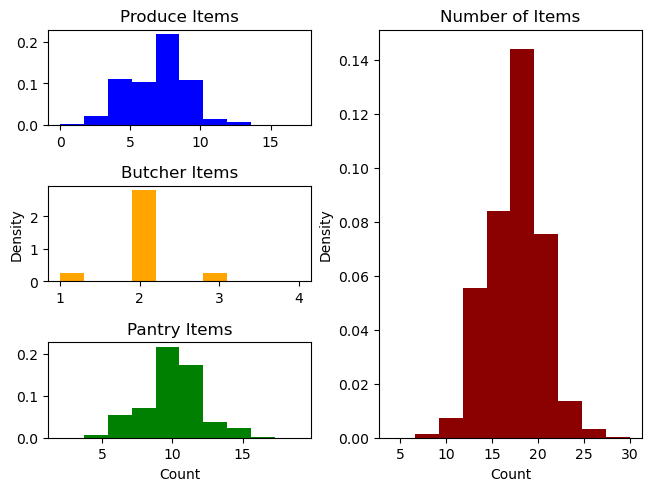

In [50]:
# Create graph object
fig = plt.figure(constrained_layout=True)
axs = fig.subplot_mosaic([['num_produce', 'num_items'], ['num_butcher', 'num_items'], ['num_pantry', 'num_items']])
                          #gridspec_kw={'width_ratios':[2, 1]})

# Plot graph

axs['num_items'].hist(dfs['base']['num_items'], density = True, color = 'darkred')
axs['num_pantry'].hist(dfs['base']['num_pantry'], density = True, color = 'green')
axs['num_butcher'].hist(dfs['base']['num_butcher'][dfs['base']['num_butcher'] > 0], density = True, color = 'orange')
axs['num_produce'].hist(dfs['base']['num_produce'], density = True, color = 'blue') 

# Set itles
axs['num_items'].set_title('Number of Items')
axs['num_produce'].set_title('Produce Items')
axs['num_butcher'].set_title('Butcher Items')
axs['num_pantry'].set_title('Pantry Items')

#Add axis labels. Use the middle and bottom of left graphs to avoid excessive text
axs['num_pantry'].set_xlabel('Count')
axs['num_items'].set_xlabel('Count')

axs['num_butcher'].set_ylabel('Density')
axs['num_items'].set_ylabel('Density')

#Show plot
plt.show()

##### Observations
This graph helps conceptualize how customers are shoping in the store. The graph's have  the shape of a normal distribution. However, the model rounds to the nearest whole number becuase people cannot buy half a box of cereal. This makes the hstogram more jagged. This is stepped effect is especally prevelent in the butcher items. Only 20% of the population goes to the butcher. To make the data meaningful. I filtered to only include customers than bought 1 or more items. This does drop customers that went ot the butcher but decided to get zero items, but there is no distinction for that in the data.

While the individual graphs seem logical, the graph of total items appears to be too low. The top of the distribution includes only about 30 items. That should not be the largest shopping trip. Real-world data could allow this model to mirror actual distribution and increase its accuracy.

#### Key Timings

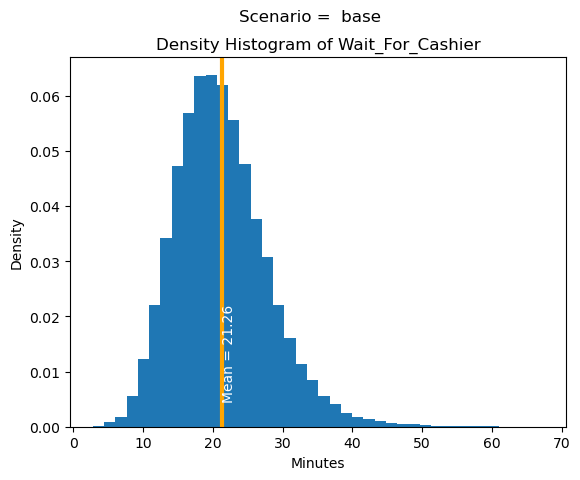

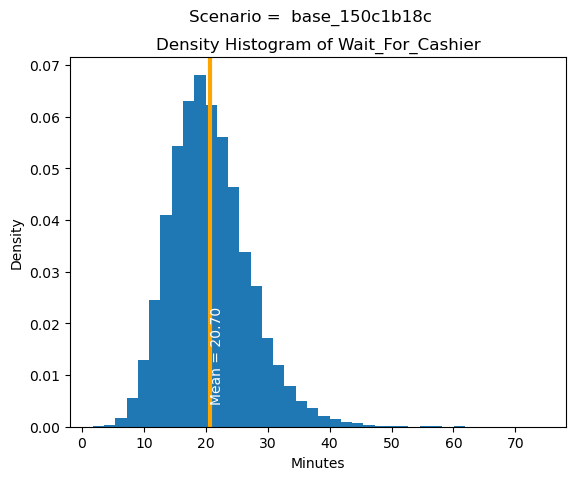

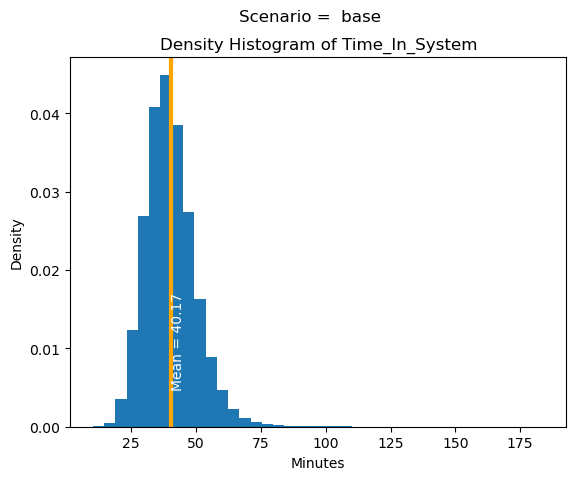

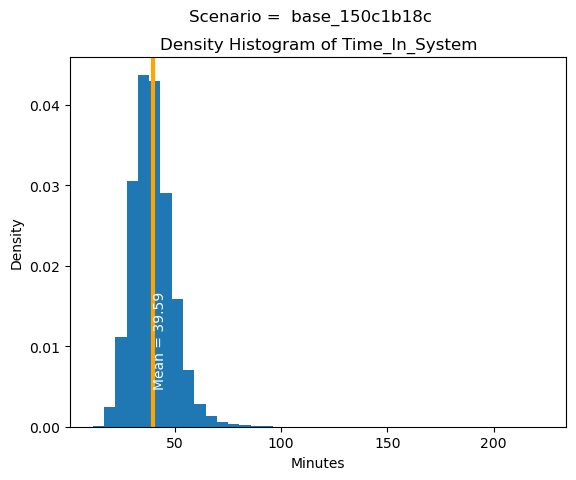

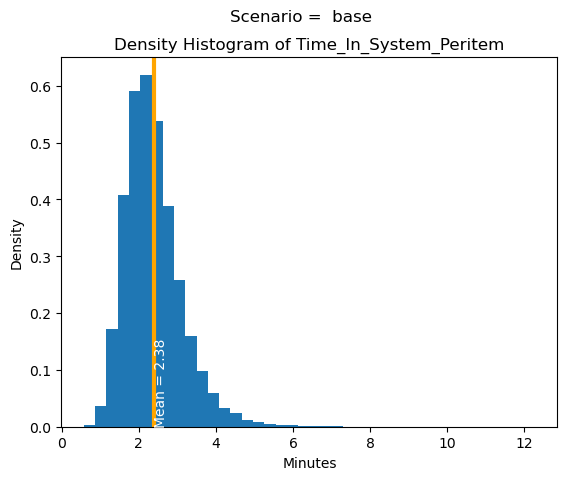

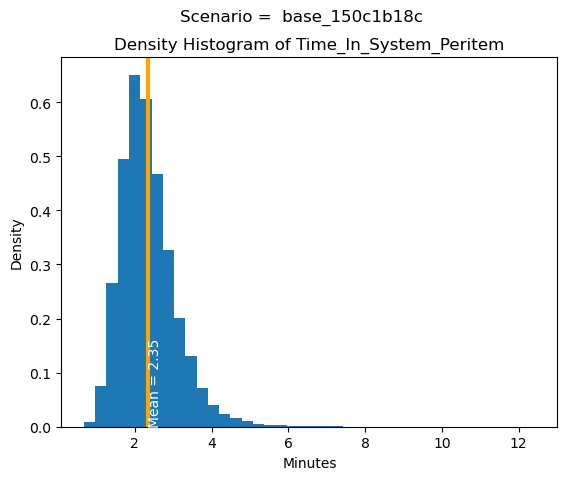

In [51]:
target_stats = ['wait_for_cashier', 'time_in_system', 'time_in_system_peritem']

for stat in target_stats:
    for scenario in dfs:

        # Create graph object
        fig, ax = plt.subplots()

        #Graph data
        ax.hist(dfs[scenario][stat], bins = 40, density = True)
        
        # Add mean line to graph
        mean = dfs[scenario][stat].mean(axis = 0)
        ax.axvline(mean, linewidth = 3, color = 'orange')
        ax.text(mean, .005, f'Mean = {mean:,.2f}',rotation=90, color = 'w')


        # Add chart elements
        ax.set_title(f'Density Histogram of {stat.title()}')
        fig.suptitle(f'Scenario =  {scenario}') #Did the matplotlib creator make a type lol
        ax.set_xlabel('Minutes')
        ax.set_ylabel('Density')

        #Show Plot
        plt.show()

##### Observation
The graphs do not show a significant difference between the base model the alternate scenario. All the graphs appear to be slightly more centered in the second model. This makes sense because the summary statistics above were similar. All the graphs have a right skew, since the model include log normal distribution for the timing of the butcher and the cashier this aspect is logical

### Skewness and Kurtosis
The graphs appear to have different levels of skewness and kurtowsis (data in the tails). These statistics can test the hypothesis above that the alternative scenario is more centered. Let's quantify that by looking at some statistics.

In [55]:
# Initialize dictionary
tail_data = {}

for scenario in dfs:
    
    #Initialize lists. Need to do  it here so blank for each scenario
    skew_stats = []
    kurtosis_stats = []
    
    for stat in target_stats:

        #Calculate tail stats and append to list. Could also use pandas
        skew_stats.append(skew(dfs[scenario][stat], bias = False))
        kurtosis_stats.append(kurtosis(dfs[scenario][stat], bias = False))
       
    #Create entry to summary dataframe
    tail_data[scenario] = {'stat': target_stats, 'skewness': skew_stats, 'kurtosis': kurtosis_stats}

In [53]:
pd.DataFrame(tail_data['base'])

,stat,skewness,kurtosis
0,wait_for_cashier,0.756034,1.368238
1,time_in_system,1.219210,6.818601
2,time_in_system_peritem,1.359909,5.377276


In [54]:
pd.DataFrame(tail_data['base_150c1b18c'])

,stat,skewness,kurtosis
0,wait_for_cashier,0.804940,1.856924
1,time_in_system,1.265289,9.033398
2,time_in_system_peritem,1.388027,5.469401


#### Observations
The measures of skewness and kurtosis have some of the largest differences between the base and alternate scenario. A perfoect normal distribution has a skewness parameter of zero. Suprisingly based on my hypothesis above, the statistics show the alternate scenario is more right skewed. The time per item is most skewed. This is concerning because it show that waiting time not shopping time is driving the time in the system. For a grocery store, some skewness is expected. There will be people who spend lots of tiem looking for a specific item or need a avocado at exactly the correct level of ripeness. However, too much skew could lead to agry reviews from disatistifed customers in the tails.

All of the distributions have high kurtosis. This is very clear in the graph. There is alot of data in the middle and little in the tails. Scipy's unbiased kurtosis for a perfect normal distribution also is zero. The time in the system is the most center around the middle. The alternate solution is the most centered. This indicates that a lot of people have similar experiences at the store.

## Further Extensions
This is just an introductory model of a grocery store. There are several steps this model could take to be more realistic and useful. 
* Change the model to account for customer variations in time of day and day of the week
* Set a mean scanning time for each cashier that holds throughout the model
* Create more departments to add specificity to the model
* Account for restocking needs
* Quantify the cost of each resource to optimize costs and time in the system